### Imports

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, ParameterGrid, cross_validate
import nltk
from nltk.tokenize import word_tokenize
from sklearn.utils import shuffle
from sklearn import decomposition
import pandas as pd
from copy import deepcopy
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import json
import itertools
import random
import warnings
import string
from shutil import copyfile
warnings.filterwarnings("ignore", category=UserWarning)

from functions import *


### Define Variables

In [2]:
global_shuffle_seed = 4
global_debug=True
global_override=True

### Load tagtog Data

In [3]:
result, clf_result = {}, {}
df_data = load_data_tagtog(['../tagtog/output'])
df_data = df_data[df_data['is_flood'].notna()]
data_true = query_dataframe(df_data, {'is_flood':True})
data_false = query_dataframe(df_data, {'is_flood':False})
print('Total:',len(df_data),'True:',len(data_true), 'False:',len(data_false))

Total: 1380 True: 663 False: 717


### Preprocess Data

In [5]:
custom_stop_words = set(['date', 'published'])
stop_words = set(nltk.corpus.stopwords.words('english'))
punctuations = set(string.punctuation)
all_stop_words = stop_words.union(punctuations, custom_stop_words)
def preprocess(x):
    x = re.sub('[^a-z\s]', ' ', x.lower())
    x = [w for w in x.split() if w not in all_stop_words and len(w)>3]
    return ' '.join(x)

In [6]:
df_data['org_text'] = df_data['text']
df_data['text'] = df_data['text'].apply(preprocess)

### Split Data

In [7]:
def make_data_ratio(df_data, test_size=None, train_size=None, shuffle_seed=4, debug=False, 
                    save_folder=None, load_folder=None, override=False, file_prefix=''):
    save_file, load_file=None, None
    if save_folder: save_file = os.path.join(save_folder,file_prefix+'data.json')
    if load_folder: load_file = os.path.join(load_folder,file_prefix+'data.json')
    
    if not override and load_file and os.path.isfile(load_file):
        if debug: print('loaded',load_file)
        js = json.load(open(load_file))
        train_df = pd.DataFrame(js['train'])
        test_df = pd.DataFrame(js['test'])
        return {'train':train_df, 'test':test_df}
    
    train_df, test_df = train_test_split(df_data, test_size=test_size, train_size=train_size, random_state=shuffle_seed, stratify=df_data['is_flood'])
    
#     true_data = df_data.loc[df_data['is_flood']==True]
#     false_data = df_data.loc[df_data['is_flood']==False]
#     train_true, test_true = train_test_split(true_data, test_size=test_size, random_state=shuffle_seed)
#     train_false, test_false = train_test_split(false_data, test_size=test_size, random_state=shuffle_seed)
    
#     train_df = pd.concat([train_true, train_false])
#     train_df = train_df.sample(n=len(train_df), random_state=shuffle_seed).reset_index(drop=True)
#     test_df = pd.concat([test_true, test_false])
#     test_df = test_df.sample(n=len(test_df), random_state=shuffle_seed).reset_index(drop=True)
    
    if debug: print('Data Loaded')

    if save_file:
        train_json = train_df.to_json(orient='records')
        test_json = test_df.to_json(orient='records')
        json.dump({'train':json.loads(train_json), 'test':json.loads(test_json)}, open(save_file,'w'), indent=2)
    return {'train':train_df, 'test':test_df}


In [8]:
result, clf_result = {}, {}
save_data_folder = 'data_splits/'
load_data_folder = 'data_splits/'
test_size = 0.2
if not os.path.isdir(save_data_folder): os.mkdir(save_data_folder)
debug=global_debug or False
override=global_override or False
data_split = make_data_ratio(df_data, test_size=test_size, save_folder=save_data_folder, load_folder=load_data_folder, 
                               debug=debug, shuffle_seed=global_shuffle_seed, override=override)


Data Loaded


In [9]:
print('Train:',len(data_split['train']), '\t\tTest:',len(data_split['test']))
print('Train is_flood:',len(data_split['train'].loc[data_split['train']['is_flood']==True]), \
'\tTrain not is_flood:',len(data_split['train'].loc[data_split['train']['is_flood']==False]))
print('Test is_flood:',len(data_split['test'].loc[data_split['test']['is_flood']==True]), \
'\tTest not is_flood:',len(data_split['test'].loc[data_split['test']['is_flood']==False]))

Train: 1104 		Test: 276
Train is_flood: 530 	Train not is_flood: 574
Test is_flood: 133 	Test not is_flood: 143


(array([762., 451., 107.,  34.,   9.,   7.,   2.,   5.,   1.,   2.]),
 array([   9. ,  278.4,  547.8,  817.2, 1086.6, 1356. , 1625.4, 1894.8,
        2164.2, 2433.6, 2703. ]),
 <a list of 10 Patch objects>)

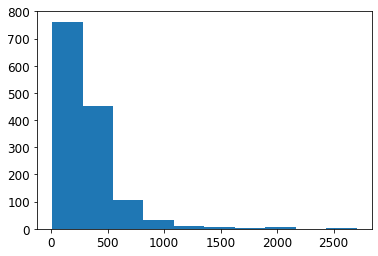

In [10]:
words = [len(f.split(' ')) for f in df_data['text']]
words.sort()
plt.hist(words)

(array([139., 204., 162.,  82.,  34.,  22.,  11.,   6.,   2.,   1.]),
 array([  15. ,  131.4,  247.8,  364.2,  480.6,  597. ,  713.4,  829.8,
         946.2, 1062.6, 1179. ]),
 <a list of 10 Patch objects>)

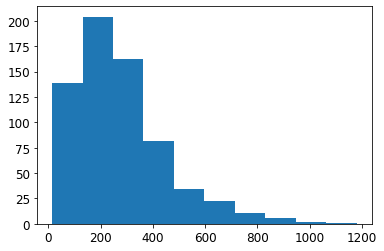

In [11]:
words = [len(f.split(' ')) for f in df_data.loc[df_data['is_flood']==True]['text']]
words.sort()
plt.hist(words)

### Classifier

In [12]:
def make_data(vect_fit, ratio):
    train, test = ratio.get('train',None), ratio.get('test',None)
    if train is None or test is None: raise Exception('Train or Test data not found')
    all_X = list(train['text'])
    
    vect = vect_fit.fit(all_X)
    trainX, testX = vect.transform(list(train['text'])), vect.transform(list(test['text']))
    trainY, testY = [1 if t else 0 for t in train['is_flood']], [1 if t else 0 for t in test['is_flood']]
    return trainX, testX, trainY, testY, vect


In [13]:
def run_classifier(clf, trainX, testX, trainY, testY):
    clf_fit = clf.fit(trainX, trainY)
    clf_pred = clf_fit.predict(testX)
    clf_acc = accuracy_score(testY, clf_pred)
    return clf_fit, clf_pred, clf_acc

In [14]:
def get_method(main_d, name):
    if name not in main_d: raise Exception('Cannot find classifier/feature_extractor name in parameter dictionary')
    d = main_d[name]
    method = d.get('method',None)
    base_method = d.get('base_method',None)
    if method and base_method: raise Exception('Cannot have method and base method both.')
    if not method and not base_method: raise Exception('Unable to parse the method from classifier/feature_extractor')
    params = d.get('params',None)
    if method:
        if params: return method, params
        else: return method, None
    if base_method:
        prev_method, prev_params = get_method(main_d, base_method)
        if params:
            for k,v in params.items(): prev_params[k] = v
        return prev_method, prev_params

def make_method(main_d, name, override_params={}):
    method, params = get_method(main_d, name)[:]
    if override_params:
        for k,v in override_params.items(): params[k] = v
    if params: return method(**params)
    else: return method()

In [15]:
def run_grid(grid, data, feature_extract, classifiers, clf_result, result, 
             debug=False, override=False, save_folder=None, load_folder=None, file_prefix=''):
    save_clf_result = {}
    vectCache, classifierCache = {}, {}
    if load_folder:
        res_file = os.path.join(load_folder,file_prefix+'clf_result.json')
        clf_res_file = os.path.join(load_folder,file_prefix+'result.json')
        if os.path.isfile(res_file): clf_result=json.load(open(res_file))
        if os.path.isfile(clf_res_file): result=json.load(open(clf_res_file))
        if os.path.isfile(res_file) and os.path.isfile(clf_res_file) and debug: print('loaded result')
    
    if override:
        clf_result, result = {}, {}
        if debug: print('OVERRIDE')
    for g in list(grid):
        try:
            feature_name = g.get('feature_extract',None)
            clf_name = g.get('classifier', None)
            if not feature_name or not clf_name:
                raise Exception('Feature Extract and Classifier Name required')
            result_key = feature_name + '-' + clf_name
            if result.get(result_key): continue
            if debug: print('Feature:', feature_name, '  Clasifier:',clf_name, '  Key:',result_key)
            
            if feature_name in vectCache:
                (trainX, testX, trainY, testY, feature2) = vectCache[feature_name]
            else:
                feature = make_method(feature_extract, feature_name)
                trainX, testX, trainY, testY, feature2 = make_data(feature, data)
                vectCache[feature_name] = (trainX, testX, trainY, testY, feature2)

            clf = make_method(classifiers, clf_name)
            clf_fit, clf_pred, clf_acc = run_classifier(clf, trainX, testX, trainY, testY)
            
            result[result_key] = {
                'feature_extract': feature_name,
                'classifier': clf_name,
                'accuracy': clf_acc
            }
            
            clf_result[result_key] = {
                'feature_extract': feature_name,
                'classifier': clf_name,
                'clf': clf_fit,
                'feature': feature2,
                'predict': clf_pred
            }
            
            save_clf_result[result_key] = {
                'feature_extract': feature_name,
                'classifier': clf_name,
                'predict': clf_pred.tolist()
            }  
        except Exception as e:
            print('Error:',e)
            continue
    if save_folder:
        json.dump(save_clf_result, open(os.path.join(load_folder,file_prefix+'clf_result.json'),'w'), indent=2)
        json.dump(result, open(os.path.join(load_folder,file_prefix+'result.json'),'w'), indent=2)
    return clf_result, result


In [16]:
def run_grid_cross_validate(grid, data, feature_extract, classifiers, result, debug=False):
    for g in list(grid):
        feature_name = g.get('feature_extract',None)
        clf_name = g.get('classifier', None)
        if not feature_name or not clf_name:
            raise Exception('Feature Extract and Classifier Name required')
        result_key = feature_name + '-' + clf_name
        if result.get(result_key): continue
        if debug: print('Feature:', feature_name, '  Clasifier:',clf_name, '  Key:',result_key)

        feature = make_method(feature_extract, 'TFIDF')
        all_X = data['text']
        all_Y = data['is_flood']
        vect = feature.fit(all_X)
        x, y = vect.transform(list(all_X)), [1 if t else 0 for t in all_Y]
        clf = make_method(classifiers, clf_name)
        cv = cross_validate(clf, x, y, cv=5,
                      scoring=('accuracy', 'precision', 'recall', 'f1'))
        result[result_key] = cv
    return result

In [17]:
def parse_result(result, clf_result=None, data=None, accuracy_threshold=None, split_by='classifier'):
    keys = list(result.keys())
    temp_df = pd.DataFrame(list(result.values()))
    if clf_result is not None and data is not None:
        presicion, recall, f1, support = [], [], [], []
        actual = [1 if f else 0 for f in list(data['test']['is_flood'])]
        for method_name in keys:
            predict = clf_result[method_name]['predict']
            pre, rec, fsc, sup = precision_recall_fscore_support(actual, predict, average='binary')
            presicion.append(pre)
            recall.append(rec)
            f1.append(fsc)
            support.append(sup)
        temp_df['f1'] = f1
        temp_df['presicion'] = presicion
        temp_df['recall'] = recall
#     temp_df['keys'] = keys
    splt_val = list(set(list(temp_df[split_by])))
    for d in splt_val:
        if accuracy_threshold:
            new_df = temp_df.loc[temp_df[split_by]==d]
            new_df = new_df.loc[new_df['accuracy']>accuracy_threshold] \
                            .drop(split_by, axis=1) \
                            .sort_values(by='accuracy',ascending=False) \
                            .reset_index(drop=True)
        else:
            new_df = temp_df.loc[temp_df[split_by]==d] \
                            .drop(split_by, axis=1) \
                            .sort_values(by='accuracy',ascending=False) \
                            .reset_index(drop=True)
        print('{}: {}'.format(split_by,d))
        print(new_df.to_markdown())
        print()

In [18]:
def compare_result(clf_result, data, method_name, conf_matrix=True, class_report=True):
    if method_name not in clf_result: raise Exception('Cannot find method')
    res = clf_result[method_name]
    new_df = data['test']
    actual = [1 if f else 0 for f in list(new_df['is_flood'])]
    new_df['predict'] = res['predict']
    if conf_matrix:
        mat = confusion_matrix(actual, res['predict'])
        plot_confusion_matrix(mat, ['Negative', 'Positive'])
        print(mat)
    if class_report: print(classification_report(actual, res['predict']))
    cr = classification_report(actual, res['predict'])
    return new_df
    

In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    plt.rcParams.update({'font.size': 18})
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [20]:
def make_vocab(ratio):
    train, test = ratio.get('train',None), ratio.get('test',None)
    if train is None or test is None: raise Exception('Train or Test data not found')
    all_X = list(train['text']) + list(test['text'])
    
    params= {
            'tokenizer': word_tokenize,
            'stop_words': 'english',
        }
    vect = CountVectorizer(**params)
    vect = vect.fit(all_X)
    return list(vect.vocabulary_.keys())

In [21]:
# Logistic Regression
vocab = make_vocab(data_split)
feature_extract = {
    'CountVect': {
        'classifier_type': 'Count Vectorizer',
        'method': CountVectorizer,
        'params': {
            'tokenizer': word_tokenize,
            'stop_words': 'english',
            'vocabulary': vocab
        }
    },
    'CountVect-2gram':{
        'base_method': 'CountVect',
        'params':{
            'ngram_range':(1,2)
        }
    },
    'CountVect-min_df-max_df':{
        'base_method': 'CountVect',
        'params':{
            'min_df': 0.05,
            'max_df': 0.95
        }
    },
    'CountVect-2gram-min_df-max_df':{
        'base_method': 'CountVect',
        'params':{
            'min_df': 0.05,
            'max_df': 0.95,
            'ngram_range':(1,2)
        }
    },
    'TFIDF': {
        'classifier_type': 'TFIDF',
        'method': TfidfVectorizer,
        'params': {
            'tokenizer': word_tokenize,
            'stop_words': 'english',
            'vocabulary': vocab
        }
    },
    'TFIDF-2gram':{
        'base_method': 'TFIDF',
        'params':{
            'ngram_range':(1,2)
        }
    },
    'TFIDF-min_df-max_df':{
        'base_method': 'TFIDF',
        'params':{
            'min_df': 0.05,
            'max_df': 0.95
        }
    },
    'TFIDF-2gram-min_df-max_df':{
        'base_method': 'TFIDF',
        'params':{
            'min_df': 0.05,
            'max_df': 0.95,
            'ngram_range':(1,2)
        }
    }
}

classifiers = {
    'RandomForest': {
        'classifier_type':'Random Forest ',
        'method': RandomForestClassifier,
        'params':{
            'class_weight':'balanced'
        }
    },
    'LinearSVC': {
        'classifier_type': 'Linear SVC',
        'method': LinearSVC,
        'params':{
            'class_weight':'balanced'
        }
    },
    'LogRegL1':{
        'classifier_type': 'Logistic Regression L1',
        'method': LogisticRegression,
        'params':{
            'penalty': 'l1',
            'class_weight':'balanced',
            'solver': 'liblinear',
            'max_iter': 1000
        }
    },
    'LogRegL2':{
        'classifier_type': 'Logistic Regression L2',
        'method': LogisticRegression,
        'params':{
            'penalty': 'l2',
            'class_weight':'balanced',
            'solver': 'liblinear',
            'max_iter': 1000
        }
    }
}

grid_parameters = {
    'feature_extract': list(feature_extract.keys()),
    'classifier': list(classifiers.keys()),
}

grid = ParameterGrid(grid_parameters)

In [128]:
# # Single Classifier

# feature_extract = single_feature_extract
# classifiers = single_classifiers
# grid_parameters = {
#     'feature_extract': list(feature_extract.keys()),
#     'classifier': list(classifiers.keys()),
# }
# grid = ParameterGrid(grid_parameters)

In [58]:
override=global_override or False
debug=global_debug or False
save_results_folder = 'results/'
load_results_folder = 'results/'
if not os.path.isdir(save_results_folder): os.mkdir(save_results_folder)
clf_result, result = run_grid(grid, data_split, feature_extract, classifiers, clf_result, result, 
                              debug=debug, override=override, save_folder=save_results_folder, 
                             load_folder=load_results_folder)


loaded result
OVERRIDE
Feature: CountVect   Clasifier: RandomForest   Key: CountVect-RandomForest
Feature: CountVect-2gram   Clasifier: RandomForest   Key: CountVect-2gram-RandomForest
Feature: CountVect-min_df-max_df   Clasifier: RandomForest   Key: CountVect-min_df-max_df-RandomForest
Feature: CountVect-2gram-min_df-max_df   Clasifier: RandomForest   Key: CountVect-2gram-min_df-max_df-RandomForest
Feature: TFIDF   Clasifier: RandomForest   Key: TFIDF-RandomForest
Feature: TFIDF-2gram   Clasifier: RandomForest   Key: TFIDF-2gram-RandomForest
Feature: TFIDF-min_df-max_df   Clasifier: RandomForest   Key: TFIDF-min_df-max_df-RandomForest
Feature: TFIDF-2gram-min_df-max_df   Clasifier: RandomForest   Key: TFIDF-2gram-min_df-max_df-RandomForest
Feature: CountVect   Clasifier: LinearSVC   Key: CountVect-LinearSVC
Feature: CountVect-2gram   Clasifier: LinearSVC   Key: CountVect-2gram-LinearSVC
Feature: CountVect-min_df-max_df   Clasifier: LinearSVC   Key: CountVect-min_df-max_df-LinearSVC
Fe

In [59]:
parse_result(result, clf_result=clf_result, data=data_split)

classifier: LogRegL1
|    | feature_extract               |   accuracy |       f1 |   presicion |   recall |
|---:|:------------------------------|-----------:|---------:|------------:|---------:|
|  0 | CountVect                     |   0.905797 | 0.901515 |    0.908397 | 0.894737 |
|  1 | CountVect-2gram               |   0.905797 | 0.901515 |    0.908397 | 0.894737 |
|  2 | CountVect-min_df-max_df       |   0.905797 | 0.901515 |    0.908397 | 0.894737 |
|  3 | CountVect-2gram-min_df-max_df |   0.905797 | 0.901515 |    0.908397 | 0.894737 |
|  4 | TFIDF                         |   0.887681 | 0.883895 |    0.880597 | 0.887218 |
|  5 | TFIDF-2gram                   |   0.887681 | 0.883895 |    0.880597 | 0.887218 |
|  6 | TFIDF-min_df-max_df           |   0.887681 | 0.883895 |    0.880597 | 0.887218 |
|  7 | TFIDF-2gram-min_df-max_df     |   0.887681 | 0.883895 |    0.880597 | 0.887218 |

classifier: LinearSVC
|    | feature_extract               |   accuracy |       f1 |   presicion |

In [22]:
parse_result(result, 0.94)

classifier: LogRegL1
|    | feature_extract               |   accuracy |
|---:|:------------------------------|-----------:|
|  0 | TFIDF                         |   0.927798 |
|  1 | TFIDF-2gram                   |   0.927798 |
|  2 | TFIDF-min_df-max_df           |   0.927798 |
|  3 | TFIDF-2gram-min_df-max_df     |   0.927798 |
|  4 | CountVect                     |   0.916968 |
|  5 | CountVect-2gram               |   0.913357 |
|  6 | CountVect-min_df-max_df       |   0.913357 |
|  7 | CountVect-2gram-min_df-max_df |   0.913357 |

classifier: LinearSVC
|    | feature_extract               |   accuracy |
|---:|:------------------------------|-----------:|
|  0 | TFIDF                         |   0.942238 |
|  1 | TFIDF-2gram                   |   0.942238 |
|  2 | TFIDF-min_df-max_df           |   0.942238 |
|  3 | TFIDF-2gram-min_df-max_df     |   0.942238 |
|  4 | CountVect-2gram               |   0.902527 |
|  5 | CountVect                     |   0.898917 |
|  6 | CountVect-min

### TFIDF-LinearSVC

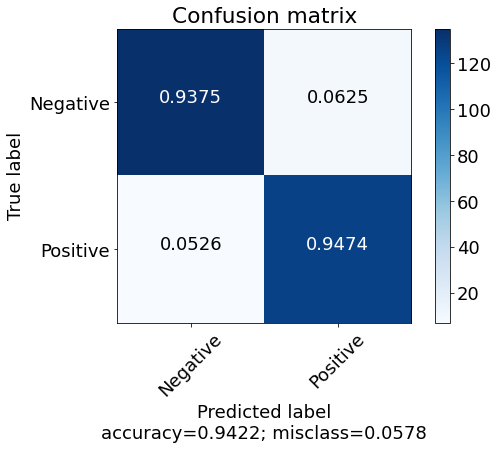

[[135   9]
 [  7 126]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       144
           1       0.93      0.95      0.94       133

    accuracy                           0.94       277
   macro avg       0.94      0.94      0.94       277
weighted avg       0.94      0.94      0.94       277

Labelled: False 	Predicted: True
florida towns told residents remain vigilant despite forecasts might dodge dorian landfall tropical storm watch issued state south atlantic coast communities northeast florida georgia south carolina raised alert levels residents filling sandbags authorities tested infrastructure hurricane drills south carolina saturday joined georgia north carolina florida declaring state emergency bahamas prime minister hubert minnis begged residents abaco grand bahamas head main island escape devastating dangerous storm want remember homes houses structures replaced lives cannot replaced minnis told news conference adding pe

In [22]:
# tn, fp
# fn, tp
temp_df = compare_result(clf_result, data_split, 'TFIDF-LinearSVC')
for row in temp_df.loc[temp_df['is_flood']!=temp_df['predict']].iterrows():
    print('Labelled:',bool(row[1]['is_flood']),'\tPredicted:',bool(row[1]['predict']))
    print(row[1]['text'])
    print()

In [23]:
# TFIDF Features
from collections import Counter
fe = clf_result['TFIDF-LinearSVC']['feature']
X = fe.transform(list(data_split['train']['text']))
vocab = list(fe.get_feature_names())
counts = X.sum(axis=0).A1
freq_dist = Counter(dict(zip(vocab, counts)))
freq_dist.most_common(10)

[('said', 66.47829495326106),
 ('water', 55.94458669079924),
 ('people', 42.732137181639686),
 ('flood', 39.233742880001614),
 ('river', 31.869304782457235),
 ('upazila', 31.547743926481004),
 ('bangladesh', 31.117933777348796),
 ('district', 26.46347356493227),
 ('areas', 24.573875963687872),
 ('level', 24.52928069899863)]

## Different test data graphs

In [23]:
vocab = make_vocab(data_split)
feature_extract = {
    'TFIDF': {
        'classifier_type': 'TFIDF',
        'method': TfidfVectorizer,
        'params': {
            'tokenizer': word_tokenize,
            'stop_words': 'english',
            'vocabulary': vocab,
            'ngram_range':(1,2),
            'min_df': 0.05,
            'max_df': 0.95
        }
    },
}

classifiers = {
    'LinearSVC': {
        'classifier_type': 'Linear SVC',
        'method': LinearSVC,
        'params':{
            'class_weight':'balanced'
        }
    },
    'LogRegL1':{
        'classifier_type': 'Logistic Regression L1',
        'method': LogisticRegression,
        'params':{
            'penalty': 'l1',
            'class_weight':'balanced',
            'solver': 'liblinear',
            'max_iter': 1000
        }
    },
    'LogRegL2':{
        'classifier_type': 'Logistic Regression L2',
        'method': LogisticRegression,
        'params':{
            'penalty': 'l2',
            'class_weight':'balanced',
            'solver': 'liblinear',
            'max_iter': 1000
        }
    },
    'RandomForest': {
        'classifier_type':'Random Forest ',
        'method': RandomForestClassifier,
        'params':{
            'class_weight':'balanced'
        }
    },
}

grid_parameters = {
    'feature_extract': list(feature_extract.keys()),
    'classifier': list(classifiers.keys()),
}

grid = ParameterGrid(grid_parameters)

In [50]:
# feature = make_method(feature_extract, 'TFIDF')
# all_X = df_data['text']
# all_Y = df_data['is_flood']
# vect = feature.fit(all_X)
# x, y = vect.transform(list(all_X)), [1 if t else 0 for t in all_Y]
# clf = make_method(classifiers, 'LinearSVC')
# cross_validate(clf, x, y, cv=5,
#               scoring=('accuracy', 'precision', 'recall', 'f1'))

In [131]:
overall_result = []
for train_size in [10,20,50,100,200,500,1000]:
    test_size = 270
    result, clf_result = {}, {}
    debug=True
    override=True
    data_split = make_data_ratio(df_data, test_size=test_size, train_size=train_size,
                               debug=debug, shuffle_seed=global_shuffle_seed, override=override)
    print(len(data_split['train']), len(data_split['test']))
    actual = [i if i==True else 0 for i in data_split['test']['is_flood']]
    clf_result, result = run_grid(grid, data_split, feature_extract, classifiers, clf_result, result, 
                              debug=debug, override=override)
    for key, val in clf_result.items():
#         if key not in overall_result: overall_result[key] = []
        predict = val['predict']
        clf_acc = accuracy_score(actual, predict)
        pre, rec, fsc, sup = precision_recall_fscore_support(actual, predict, average='binary')
        d = { 'key':key, 'train_size':train_size, 'test_size':test_size, 'accuracy':clf_acc, 'precision':pre, 
            'recall':rec, 'f1':fsc,'predict':predict, 'actual': actual
        }
        overall_result.append(d)

Data Loaded
10 270
OVERRIDE
Feature: TFIDF   Clasifier: LinearSVC   Key: TFIDF-LinearSVC
Feature: TFIDF   Clasifier: LogRegL1   Key: TFIDF-LogRegL1
Feature: TFIDF   Clasifier: LogRegL2   Key: TFIDF-LogRegL2
Data Loaded
20 270
OVERRIDE
Feature: TFIDF   Clasifier: LinearSVC   Key: TFIDF-LinearSVC
Feature: TFIDF   Clasifier: LogRegL1   Key: TFIDF-LogRegL1
Feature: TFIDF   Clasifier: LogRegL2   Key: TFIDF-LogRegL2
Data Loaded
50 270
OVERRIDE
Feature: TFIDF   Clasifier: LinearSVC   Key: TFIDF-LinearSVC
Feature: TFIDF   Clasifier: LogRegL1   Key: TFIDF-LogRegL1
Feature: TFIDF   Clasifier: LogRegL2   Key: TFIDF-LogRegL2
Data Loaded
100 270
OVERRIDE
Feature: TFIDF   Clasifier: LinearSVC   Key: TFIDF-LinearSVC
Feature: TFIDF   Clasifier: LogRegL1   Key: TFIDF-LogRegL1
Feature: TFIDF   Clasifier: LogRegL2   Key: TFIDF-LogRegL2
Data Loaded
200 270
OVERRIDE
Feature: TFIDF   Clasifier: LinearSVC   Key: TFIDF-LinearSVC
Feature: TFIDF   Clasifier: LogRegL1   Key: TFIDF-LogRegL1
Feature: TFIDF   Clasi

In [148]:
pd.DataFrame.from_dict(overall_result) \
                .drop(['predict','actual'], axis=1) \
                .sort_values(['train_size', 'accuracy'])

,key,train_size,test_size,accuracy,precision,recall,f1
1,TFIDF-LogRegL1,10,270,0.518519,0.000000,0.000000,0.000000
0,TFIDF-LinearSVC,10,270,0.814815,0.844828,0.753846,0.796748
2,TFIDF-LogRegL2,10,270,0.829630,0.833333,0.807692,0.820313
4,TFIDF-LogRegL1,20,270,0.518519,0.000000,0.000000,0.000000
3,TFIDF-LinearSVC,20,270,0.781481,0.831776,0.684615,0.751055
5,TFIDF-LogRegL2,20,270,0.796296,0.826087,0.730769,0.775510
7,TFIDF-LogRegL1,50,270,0.662963,0.634483,0.707692,0.669091
8,TFIDF-LogRegL2,50,270,0.862963,0.854962,0.861538,0.858238
6,TFIDF-LinearSVC,50,270,0.866667,0.873016,0.846154,0.859375
10,TFIDF-LogRegL1,100,270,0.740741,0.826087,0.584615,0.684685


### BERT Classifier

In [149]:
overall_result_bert = [
    {'key': 'BERT-512', 'train_size': 10, 'test_size': 270, 'accuracy': 0.6148148148148148, 
     'precision': 0.6382978723404256, 'recall': 0.46153846153846156, 'f1': 0.5357142857142858},
    {'key': 'BERT-512', 'train_size': 20, 'test_size': 270, 'accuracy': 0.8333333333333334, 
     'precision': 0.8455284552845529, 'recall': 0.8, 'f1': 0.8221343873517788},
    {'key': 'BERT-512', 'train_size': 50, 'test_size': 270, 'accuracy': 0.9, 
     'precision': 0.8705035971223022, 'recall': 0.9307692307692308, 'f1': 0.899628252788104},
    {'key': 'BERT-512', 'train_size': 100, 'test_size': 270, 'accuracy': 0.9148148148148149, 
     'precision': 0.8741258741258742, 'recall': 0.9615384615384616, 'f1': 0.9157509157509157},
    {'key': 'BERT-512', 'train_size': 200, 'test_size': 270, 'accuracy': 0.9074074074074074, 
     'precision': 0.8888888888888888, 'recall': 0.9230769230769231, 'f1': 0.9056603773584906},
    {'key': 'BERT-512', 'train_size': 500, 'test_size': 270, 'accuracy': 0.9222222222222223, 
     'precision': 0.9097744360902256, 'recall': 0.9307692307692308, 'f1': 0.920152091254753},
    {'key': 'BERT-512', 'train_size': 1000, 'test_size': 270, 'accuracy': 0.9259259259259259, 
     'precision': 0.9044117647058824, 'recall': 0.9461538461538461, 'f1': 0.9248120300751879}
]
r2 = []
for i in overall_result_bert:
    i['predict'] = []
    i['actual'] = []
    r2.append(i)
overall_result_bert = r2
pd.DataFrame.from_dict(overall_result_bert) \
                .drop(['predict','actual'], axis=1) \
                .sort_values(['train_size', 'accuracy'])

,key,train_size,test_size,accuracy,precision,recall,f1
0,BERT-512,10,270,0.614815,0.638298,0.461538,0.535714
1,BERT-512,20,270,0.833333,0.845528,0.800000,0.822134
2,BERT-512,50,270,0.900000,0.870504,0.930769,0.899628
3,BERT-512,100,270,0.914815,0.874126,0.961538,0.915751
4,BERT-512,200,270,0.907407,0.888889,0.923077,0.905660
5,BERT-512,500,270,0.922222,0.909774,0.930769,0.920152
6,BERT-512,1000,270,0.925926,0.904412,0.946154,0.924812


### Weak Classifier

In [219]:
# Evaluate weak classifier
words = ['flood', 'inundat', 'cyclone']
flood_data, non_flood_data = [], []
for row in df_data.iterrows():
    text = row[1]['text']
    if any(word in text for word in keys): flood_data.append(row[1])
    else: non_flood_data.append(row[1])
weak_flood = pd.DataFrame(flood_data)
weak_not_flood = pd.DataFrame(non_flood_data)

In [249]:
from all_papers import *

In [250]:
# def get_id_data(paper_name: str, query_id=None, connect_filename=None, query_term='all', debug=True):
#     """
#     given an id or connect_filename, get data related to it
#     :param paper_name:
#     :param query_id:
#     :param connect_filename:
#     :param query_term: 'all' to get all data, or enter a term to query (eg. datePublished)
#     :param debug:
#     :return:
#     """
#     root_folder = '/Users/tejitpabari/Desktop/BangladeshFloodResearch/nlp_flood_research/article_scraping/paper_data'
#     paper_name = parse_paper_name(paper_name)
#     data = json.load(open(os.path.join(root_folder, 'all_paper_data',paper_name+'1_data.json')))
#     data_id = None
#     if query_id:
#         for d in data:
#             if d['id']==query_id:
#                 data_id=d
#                 break
#         if not data_id: raise Exception('ID: {} not found in paper: {}'.format(query_id, paper_name))
#     elif connect_filename:
#         for d in data:
#             if 'connect_filename' in d and d['connect_filename']==connect_filename:
#                 data_id=d
#                 break
#         if not data_id: raise Exception('Connect_filename: {} not found in paper: {}'.format(connect_filename, paper_name))
#     else: raise Exception('Please enter a query_id or a connect_filename')

In [39]:
newspaper_mapping = {'daily_star':'thedailystar', 'dhaka_tribune': 'dhakaTribune', 'ny_times':'nytimes'}
def text_link(df, i):
    link = get_id_data(newspaper_mapping[df['newspaper'].iloc[i]], query_id=df['doc_id'].iloc[i])['meta']['link']
    print(df['org_text'].iloc[i])
    print(link)

In [267]:
wrong_weak_flood = weak_flood[weak_flood['is_flood']==False]
ban = wrong_weak_flood[wrong_weak_flood['is_bangladesh']==True]
ban2 = ban[ban['org_text'].str.contains('cyclon')]

In [282]:
wrong_weak_not_flood = weak_not_flood[weak_not_flood['is_flood']==True]
ban = wrong_weak_not_flood[wrong_weak_not_flood['is_bangladesh']==True]
text_link(ban, 3)

Date Published:2018-09-09 00:00:00 More than 2,000 houses, 500 business centres, and other establishments have already been washed away The devastating erosion of the Padma River has once again taken a serious turn in Naria upazila of Shariatpur district. According to sources, more than: 2,000 houses, 500 business centres, several schools, mosques and other establishments have been washed away by the consequences of aggressive river erosion. The river is threatening increasingly more areas. On Sunday morning, a big portion of Naria Upazila Health Complex and a mosque adjacent to the hospital also washed away. At least 12 hospital buildings are at risk of being washed away at any time, said locals. In the last month, the river has devoured several multi-storey buildings, a mosque, 2,000 business centres, 300 shops, and others establishments located on the riverbank. A1.50km area, from Naria Banshtola to Purba Naria, was washed away by the river in the last couple of days-- but the autho

In [232]:
ban['doc_id'].iloc[1]

'9498ced5-0aef-4e72-ac26-92070adc88a2'

In [54]:
from itertools import chain, combinations
weak_res = []
words = ['flood', 'inundat', 'cyclone']

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

actual = list(data_split['test']['is_flood'])
for keys in powerset(words):
    if len(keys)>0:
        predict = []
        for row in data_split['test'].iterrows():
            text = row[1]['text']
            if any(word in text for word in keys): predict.append(True)
            else: predict.append(False)
        clf_acc = accuracy_score(actual, predict)
        pre, rec, fsc, sup = precision_recall_fscore_support(actual, predict, average='binary')
        d = { 'key':'-'.join(keys), 'train_size':0, 'test_size':len(data_split['test']), 
             'accuracy':clf_acc, 'precision':pre, 
            'recall':rec, 'f1':fsc,'predict':predict, 'actual': actual
        }
        weak_res.append(d)

In [56]:
len(data_split['test'][data_split['test']['is_flood']==True])

423

In [55]:
pd.DataFrame.from_dict(weak_res) \
                .drop(['predict','actual'], axis=1) \
                .sort_values(['train_size', 'accuracy'])

,key,train_size,test_size,accuracy,precision,recall,f1
2,cyclone,0,880,0.523864,0.518868,0.130024,0.207940
5,inundat-cyclone,0,880,0.701136,0.781690,0.524823,0.628006
1,inundat,0,880,0.715909,0.926108,0.444444,0.600639
4,flood-cyclone,0,880,0.728409,0.647910,0.952719,0.771292
0,flood,0,880,0.732955,0.657191,0.929078,0.769833
6,flood-inundat-cyclone,0,880,0.732955,0.649206,0.966903,0.776828
3,flood-inundat,0,880,0.738636,0.658979,0.945626,0.776699


### OVERALL CLASSIFIER

In [161]:
result_df = pd.DataFrame.from_dict(overall_result + overall_result_bert + weak_res) \
                .drop(['predict','actual'], axis=1) \
                .sort_values(['train_size', 'accuracy'])
result_df['accuracy'] = result_df['accuracy'].apply(lambda x:round(x,2))
result_df['precision'] = result_df['precision'].apply(lambda x:round(x,2))
result_df['recall'] = result_df['recall'].apply(lambda x:round(x,2))
result_df['f1'] = result_df['f1'].apply(lambda x:round(x,2))
print(result_df.reset_index(drop=True).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
                   key &  train\_size &  test\_size &  accuracy &  precision &  recall &    f1 \\
\midrule
               cyclone &           0 &       1380 &      0.53 &       0.56 &    0.14 &  0.22 \\
       inundat-cyclone &           0 &       1380 &      0.69 &       0.78 &    0.49 &  0.60 \\
               inundat &           0 &       1380 &      0.69 &       0.91 &    0.41 &  0.56 \\
         flood-cyclone &           0 &       1380 &      0.73 &       0.65 &    0.95 &  0.77 \\
                 flood &           0 &       1380 &      0.73 &       0.66 &    0.93 &  0.77 \\
 flood-inundat-cyclone &           0 &       1380 &      0.73 &       0.65 &    0.97 &  0.78 \\
         flood-inundat &           0 &       1380 &      0.74 &       0.66 &    0.95 &  0.78 \\
        TFIDF-LogRegL1 &          10 &        270 &      0.52 &       0.00 &    0.00 &  0.00 \\
              BERT-512 &          10 &        270 &      0.61 &       0.64 &    0.46 &  0.5

### cross validation

In [188]:
overall_result = []
clf_result = {}
debug=True
override=True
clf_result = run_grid_cross_validate(grid, df_data, feature_extract, classifiers, clf_result, debug=debug)
for key, val in clf_result.items():
    d = { 'key':key,
         'mean_accuracy': round(np.mean(val['test_accuracy']),2), 
         'mean_precision': round(np.mean(val['test_precision']),2),
         'mean_recall': round(np.mean(val['test_recall']),2), 
         'mean_f1': round(np.mean(val['test_f1']),2),
         'accuracy':val['test_accuracy'], 'precision':val['test_precision'],
         'recall':val['test_recall'], 'f1':val['test_f1']
    }
    overall_result.append(d)

Feature: TFIDF   Clasifier: LinearSVC   Key: TFIDF-LinearSVC
Feature: TFIDF   Clasifier: LogRegL1   Key: TFIDF-LogRegL1
Feature: TFIDF   Clasifier: LogRegL2   Key: TFIDF-LogRegL2
Feature: TFIDF   Clasifier: RandomForest   Key: TFIDF-RandomForest


In [193]:
overall_result.append(
    {'key': 'BERT-512', 
     'accuracy': [0.9456521739130435, 0.9166666666666666, 
                  0.9347826086956522, 0.927536231884058, 0.9202898550724637], 
     'precision': [0.9389312977099237, 0.8506493506493507, 
                   0.9060402684563759, 0.9121621621621622, 0.9090909090909091], 
     'recall': [0.9461538461538461, 1.0, 
                0.9712230215827338, 0.9507042253521126, 0.9090909090909091], 
     'f1': [0.9425287356321839, 0.9192982456140351, 
            0.9375, 0.9310344827586207, 0.9090909090909091], 
     'mean_accuracy': 0.9289855072463767, 'mean_precision': 0.9033747976137443, 
     'mean_recall': 0.9554344004359203, 'mean_f1': 0.9278904746191496}
)


In [194]:
print(pd.DataFrame.from_dict(overall_result) \
                .drop(['accuracy','precision', 'recall', 'f1'], axis=1) \
                .sort_values(['mean_accuracy']).to_latex(index=False))
                

\begin{tabular}{lrrrr}
\toprule
                key &  mean\_accuracy &  mean\_precision &  mean\_recall &  mean\_f1 \\
\midrule
     TFIDF-LogRegL1 &       0.900000 &        0.900000 &     0.890000 &  0.89000 \\
     TFIDF-LogRegL2 &       0.920000 &        0.890000 &     0.940000 &  0.91000 \\
 TFIDF-RandomForest &       0.920000 &        0.870000 &     0.970000 &  0.92000 \\
           BERT-512 &       0.928986 &        0.903375 &     0.955434 &  0.92789 \\
    TFIDF-LinearSVC &       0.930000 &        0.910000 &     0.950000 &  0.93000 \\
\bottomrule
\end{tabular}



### 500 train_size

In [116]:
overall_result = []
train_size = 500
test_size = len(df_data)-train_size
result, clf_result = {}, {}
debug=True
override=True
data_split = make_data_ratio(df_data, test_size=test_size, train_size=train_size,
                           debug=debug, shuffle_seed=global_shuffle_seed, override=override)
print(len(data_split['train']), len(data_split['test']))

actual = [1 if i==True else 0 for i in data_split['test']['is_flood']]
clf_result, result = run_grid(grid, data_split, feature_extract, classifiers, clf_result, result, 
                              debug=debug, override=override)
for key, val in clf_result.items():
#         if key not in overall_result: overall_result[key] = []
    predict = val['predict']
    clf_acc = accuracy_score(actual, predict)
    pre, rec, fsc, sup = precision_recall_fscore_support(actual, predict, average='binary')
    d = { 'key':key, 'train_size':train_size, 'test_size':test_size, 'accuracy':clf_acc, 'precision':pre, 
        'recall':rec, 'f1':fsc,'predict':predict, 'actual': actual
    }
    overall_result.append(d)

Data Loaded
500 880
OVERRIDE
Feature: TFIDF   Clasifier: LinearSVC   Key: TFIDF-LinearSVC
Feature: TFIDF   Clasifier: LogRegL1   Key: TFIDF-LogRegL1
Feature: TFIDF   Clasifier: LogRegL2   Key: TFIDF-LogRegL2
Feature: TFIDF   Clasifier: RandomForest   Key: TFIDF-RandomForest


In [102]:
# json.dump(json.loads(data_split['test'].to_json(orient='records')), open('test.json','w'), indent=2)

In [117]:
overall_result.append({'key': 'BERT-512', 'train_size': 500, 'test_size': 880, 'accuracy': 0.928409090909091, 'precision': 0.9054054054054054, 'recall': 0.950354609929078, 'f1': 0.9273356401384083, 'predict': [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]})


In [118]:
actualBERT = [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]
actualBERT==actual

True

In [119]:
df_ref = data_split['test'].copy()

In [124]:
for a in overall_result:
    df_ref[a['key']] = a['predict']
df_ref['actual'] = actual

In [125]:
def text_link(df, i):
    link = get_id_data(newspaper_mapping[df['newspaper'].iloc[i]], query_id=df['doc_id'].iloc[i])['meta']['link']
    print(df['org_text'].iloc[i])
    print(link)

In [147]:
cl = 'TFIDF-LinearSVC'
d = df_ref[df_ref.apply(lambda x: x[cl]==0 and x['BERT-512']==1 and x['actual']==1, axis=1)]
print(len(d))
# text_link(d, 0)

14


In [158]:
cl = 'TFIDF-LogRegL1'
d = df_ref[df_ref.apply(lambda x: x[cl]==0 and x['BERT-512']==1 and x['actual']==1, axis=1)]
print(len(d))
# text_link(d, 8)

50


In [180]:
cl = 'TFIDF-LogRegL2'
d = df_ref[df_ref.apply(lambda x: x[cl]==0 and x['BERT-512']==1 and x['actual']==1, axis=1)]
print(len(d))
# text_link(d, 19)

27


In [204]:
cl = 'TFIDF-RandomForest'
d = df_ref[df_ref.apply(lambda x: x[cl]==0 and x['BERT-512']==1 and x['actual']==1, axis=1)]
print(len(d))
# text_link(d, 3)
d['org_text'].iloc[2]

13


'136 Are Dead as Floods Hit Bangladesh and North India 1984-05-25T05:00:00.000Z Floods in northeastern India and in Bangladesh were reported today to have left 136 people dead, hundreds of thousands homeless and crops devastated. In Bangladesh the death toll was 91. @#'

In [123]:
pd.DataFrame.from_dict(overall_result) \
                .drop(['predict','actual'], axis=1) \
                .sort_values(['train_size', 'accuracy'])

,key,train_size,test_size,accuracy,precision,recall,f1
1,TFIDF-LogRegL1,500,880,0.885227,0.904523,0.851064,0.876979
2,TFIDF-LogRegL2,500,880,0.904545,0.893271,0.910165,0.901639
3,TFIDF-RandomForest,500,880,0.906818,0.873085,0.943262,0.906818
0,TFIDF-LinearSVC,500,880,0.914773,0.897260,0.929078,0.912892
4,BERT-512,500,880,0.928409,0.905405,0.950355,0.927336


# Classify new data

In [18]:
root_folder = 'paper_data'
newspapers = ['bdnews', 'dailySun', 'prothomalo', 'dailyObserver', 'newAge', 
              'dhakaTribune', 'thedailystar', 'theIndependent', 'theNewNation']
# newspapers += ['nytimes']
# newspapers_files = [os.path.join(root_folder, n, n+'2_data.json') for n in newspapers]
newspapers_files = [os.path.join(root_folder, 'all_paper_data', n+'1_data.json') for n in newspapers]

idSet = set(df_data['doc_id'])

def classify_new_data(newspapers_files):
    new_data = pd.DataFrame()
    text_set = set()
    for i,newspapers_path in enumerate(newspapers_files):
        temp_data = json.load(open(newspapers_path))
        temp_data2 = []
        for t in temp_data:
            if t['id'] in idSet: continue
            temp_dict = t['meta']
            for k,v in t['article'].items(): temp_dict[k]=v
            temp_dict['id'] = t['id']
            temp_dict['connect_filename'] = t.get('connect_filename',None)
            temp_dict['newspaper'] = newspapers[i]
            if t['article']['text'] not in text_set: text_set.add(t['article']['text'])
            else: continue
            temp_data2.append(temp_dict)
        temp_df = pd.DataFrame(temp_data2)
        new_data = pd.concat([new_data, temp_df])
    new_data = new_data.fillna("")
    new_data = new_data[new_data['connect_filename']==""]
    print(len(new_data))
    return new_data
### New data from newspapers


### NYTIMES new data
# newspapers_files = ['../article_scraping/paper_data/thedailystar/theDailyStar3_data.json']
new_data = classify_new_data(newspapers_files)

36123


In [19]:
new_data.head(2)

,abstract,news_keywords,description,keywords,datePublished,dateModified,link,query_info,headline,text,id,connect_filename,newspaper,authors
0,,,Massive blackout brings Bangladesh to its knees,[Bangladesh],2014-11-01 00:00:00,,https://bdnews24.com/bangladesh/2014/11/01/mas...,"{'query': 'bangladesh ""floods""', 'paper': 'bdn...",Massive blackout brings Bangladesh to its knees,Date Published:2014-11-01 00:00:00 \nSeve...,5da996ad-b1a9-490e-9c89-d8a34ecc5741,,bdnews,
1,,,Nawaz Sharif praises Bangladesh,[Bangladesh],2014-11-26 00:00:00,,https://bdnews24.com/bangladesh/2014/11/26/naw...,"{'query': 'bangladesh ""floods""', 'paper': 'bdn...",Nawaz Sharif praises Bangladesh,Date Published:2014-11-26 00:00:00 \nHe e...,d8c9576a-e4b4-4cfe-af54-dd208f699d75,,bdnews,


In [26]:
new_data['org_text'] = new_data['text']
new_data['text'] = new_data['text'].apply(preprocess)
jdata = json.loads(new_data[['datePublished','text','org_text','id','newspaper']].to_json(orient='records'))
json.dump(jdata,open('new_data.json','w'))

In [25]:
def loop_data_train_test(classifier, feature, data_df=None, predictions_folder = 'predictions',
                         prev_true_data_df=None, prev_false_data_df=None, save=True):
#     if data_df is None and prev_false_data_df is None: raise Exception('No df_data or prev_dalse_data_df')
#     if prev_false_data_df is not None: data_df = prev_false_data_df
    to_keep_cols = ['datePublished', 'text', 'doc_id', 'connect_filename', 'newspaper', 'is_flood']
    data_df['new_text'] = data_df['text'].apply(preprocess)
    
    test_features = feature.transform(list(data_df['new_text']))
    test_pred = classifier.predict(test_features)
    
    data_df['is_flood'] = [bool(i) for i in test_pred]
    data_df['doc_id'] = data_df['id']
    data_df = data_df[to_keep_cols]
    true_new_data = data_df.loc[data_df['is_flood']]
    false_new_data = data_df.loc[~data_df['is_flood']]
    print('Total New Data: {}\tTrue new Data: {}'.format(len(data_df), len(true_new_data)))
    
    if prev_true_data_df is not None: df_true_new_data = pd.concat([prev_true_data_df, true_new_data])
    else: df_true_new_data = true_new_data
    js = df_true_new_data.to_json(orient='records')
    if save: json.dump(json.loads(js), open(os.path.join(predictions_folder, 'predicted_isflood.json'), 'w'), indent=2)
    
    if prev_false_data_df is not None: df_false_new_data = pd.concat([prev_false_data_df, false_new_data])
    else: df_false_new_data = false_new_data
    js = df_false_new_data.to_json(orient='records')
    if save: json.dump(json.loads(js), open(os.path.join(predictions_folder, 'predicted_not_isflood.json'), 'w'), indent=2)
    return df_true_new_data, false_new_data

In [26]:
key = 'TFIDF-LinearSVC'
feature = clf_result[key]['feature']
classifier = clf_result[key]['clf']
prev_true_data_df, prev_false_data_df = None, None
# prev_true_data_df, prev_false_data_df = get_new_predicted_data()
save = False
df_true_new_data, false_new_data = loop_data_train_test(classifier, feature, new_data, 'predictions',
                                                        prev_true_data_df, prev_false_data_df, save=save)

Total New Data: 344709	True new Data: 1873


In [27]:
df_true_new_dataBangla = df_true_new_data[df_true_new_data['text'].str.contains('bangladesh', flags=re.IGNORECASE)]


In [28]:
len(df_true_new_dataBangla)

290

In [75]:
printCounts = 0
st = ""
for row in df_true_new_dataBangla.iterrows():
    entry = row[1]
    if '2009' in entry['datePublished']:
        st += '\n' + entry['text'] + '\n'
        st += '\n---------------------\n'
        printCounts+=1
    if printCounts == 10: break
open('trialCheck.txt','w').write(st)

37986

In [30]:
from collections import defaultdict
dateCounts = defaultdict(int)
for i in df_true_new_dataBangla['datePublished']:
    try:
        year = i.split('-')[0]
        if year: dateCounts[year] += 1
    except Exception as e:
        print(e)
        print(i)
dateCounts

defaultdict(int,
            {'2007': 85,
             '2008': 52,
             '2009': 29,
             '2010': 35,
             '2011': 19,
             '2012': 26,
             '2013': 22,
             '2014': 22})

### Upload data

In [78]:
def upload_data(data, upload_folder, n=1000):
    if not os.path.isdir(upload_folder): os.mkdir(upload_folder)
    for row in data.sample(n=n, random_state=32).iterrows():
        iid = row[1]['doc_id']
        newspaper = row[1]['newspaper']
        filename = '{}_data_{}@.txt'.format(newspaper, iid)
        text = row[1]['text'] + '\n@#@'
        open(os.path.join(upload_folder, filename),'w').write(text)
nd = df_data[df_data['is_flood']==True]
nd = nd[nd['newspaper'].notna()]
nd = nd[nd['doc_id'].notna()]
upload_data(nd, 'upload-flood', 200)

In [99]:
def get_id_from_filename(filename):
    if('_data_') in filename:
        splt =  filename.replace('@','').split('_data_')
        if len(splt)>1:
            doc_id = splt[1].replace('_', '-')
            doc_id = doc_id.split('.')[0]
            return doc_id

def upload_data(data, upload_folder, prev_ann_folder, n=1000):
    if not os.path.isdir(upload_folder): os.mkdir(upload_folder)
    ids = {row[1]['doc_id']:row[1]['org_text'] for row in data.iterrows()}
    anns = {}
    for filename in os.listdir(prev_ann_folder):
        if '.json' in filename:
            iid = get_id_from_filename(filename)
            if iid in ids:
                anns[iid] = filename
    for iid in random.sample(list(anns.keys()), n):
        filepath = anns[iid]
        filename = filepath.split('-')[1].split('.')[0]
        txt_file = filename + '.txt'
        annjson = filename + '.ann.json'
        copyfile(os.path.join(prev_ann_folder, filepath), os.path.join(upload_folder, annjson))
        text = str(ids[iid]) + '\n@#@'
        open(os.path.join(upload_folder, txt_file),'w').write(text)
        
nd = df_data[df_data['is_flood']==True]
nd = nd[nd['newspaper'].notna()]
nd = nd[nd['doc_id'].notna()]
upload_data(nd, 'upload-flood', '../tagtog/output', 200)
